In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
print('...')

...


Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


Text(0.5,1,'Example Not-car Image')

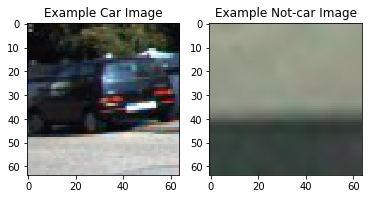

In [7]:
folder_list = [
    'vehicles_smallset/cars1/', 
    'vehicles_smallset/cars2/', 
    'vehicles_smallset/cars3/',
    'non-vehicles_smallset/notcars1/', 
    'non-vehicles_smallset/notcars2/', 
    'non-vehicles_smallset/notcars3/'
]

images = []
for folder in folder_list:
    contents = os.listdir(folder)
    images.extend([os.path.join(folder, x) for x in contents if x.endswith('.jpeg')])

cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Define a function to return some characteristics of the dataset
# Shamelessly copied from Lesson 19: Data Exploration
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    img = mpimg.imread(images[0])
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')



Text(0.5,1,'HOG Visualization')

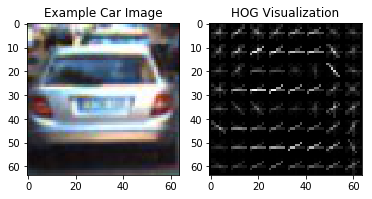

In [24]:
# Generate a random index to look at a car image
car_ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[car_ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient=8, 
                        pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

Text(0.5,1,'HOG Visualization')

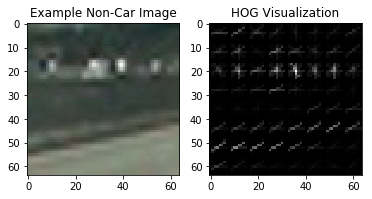

In [17]:
# Generate a random index to look at a not-car image
notcar_ind = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(notcars[notcar_ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient=8, 
                        pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
